In [187]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [188]:
measurements = pd.read_csv('measurements_with_postcode.csv')
postcodes = pd.read_csv('data/German-Zip-Codes.csv', sep=';')
subsidies = pd.read_csv('niedersachsen-subsidies.csv')

In [189]:
subsidies['postcode'] = subsidies.recipient_postcode.str.slice(3)

In [190]:
lr = linear_model.LinearRegression()


In [191]:
measurements.Datum = pd.to_datetime(measurements.Datum, format='%Y-%m-%d')


In [192]:
def correlate_subsidies(year=2016, scheme='EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren'):
    subs_f = subsidies[(subsidies['year'] == year) & (subsidies['scheme'] == scheme)]    
    subs_post = subs_f.groupby('postcode')['amount'].agg('sum')
    measurement_year = year
    if year == 2016:
        measurement_year = 2015
    
    meas_post = measurements[measurements.Datum.dt.year == measurement_year].groupby('postcode')['Messwert'].agg('mean')
    meas_without_sub = [p for p in subs_post.index if int(p) not in meas_post]
    meas_with_sub = [p for p in subs_post.index if int(p) in meas_post]
    
    amount_arr = np.array([[v] for v in subs_post[meas_with_sub]])
    meas_arr = np.array(meas_post[[int(i) for i in meas_with_sub]])
    
    lr.fit(amount_arr, meas_arr)
    
    fig, ax = plt.subplots()
    ax.scatter(amount_arr, meas_arr)
    ax.plot([amount_arr.min(), amount_arr.max()], [meas_arr.min(), meas_arr.max()], 'k--')
    ax.plot(amount_arr, lr.predict(amount_arr), 'k', color='red')

    ax.set_xlabel('Subsidies Total')
    ax.set_ylabel('Nitrate average')
    plt.show()
    
    meas_predicted =  lr.predict(amount_arr)
    
    
    print("Correlation: {0:.2f}".format(np.corrcoef(amount_arr.flatten(),meas_arr)[0][1]))
    # The coefficients
    print('Coefficients: \n', lr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
      % mean_squared_error(meas_arr, meas_predicted))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % r2_score(meas_arr, meas_predicted))



# 2016 - EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren

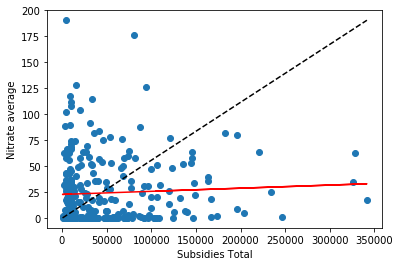

Correlation: 0.05
Coefficients: 
 [3.00005234e-05]
Mean squared error: 1005.16
Variance score: 0.00


In [193]:
correlate_subsidies(year=2016, scheme='EGFL: Befristete Sonderbeihilfe für Erzeuger der Tierhaltungssektoren' )

# 2014 - EGFL: Direktzahlungen

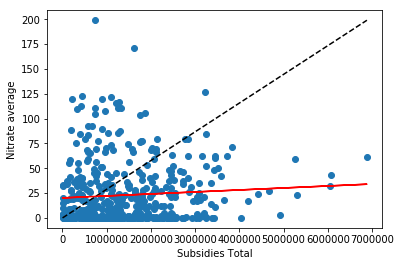

Correlation: 0.07
Coefficients: 
 [2.00377017e-06]
Mean squared error: 927.77
Variance score: 0.00


In [194]:
correlate_subsidies(year=2014, scheme='EGFL: Direktzahlungen' )

# 2016 - EGFL: Basisprämie

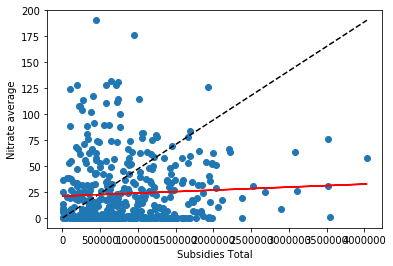

Correlation: 0.06
Coefficients: 
 [2.88340494e-06]
Mean squared error: 989.84
Variance score: 0.00


In [195]:
correlate_subsidies(year=2016, scheme='EGFL: Basisprämie' )

# 2016 - ELER: Agrarumwelt- und Klimaschutzmaßnahmen

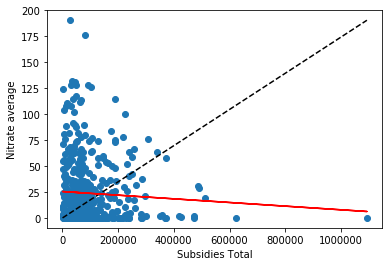

Correlation: -0.06
Coefficients: 
 [-1.75848975e-05]
Mean squared error: 1005.96
Variance score: 0.00


In [196]:
correlate_subsidies(year=2016, scheme='ELER: Agrarumwelt- und Klimaschutzmaßnahmen' )

# Top 10 Postcode Subsidies

## By total

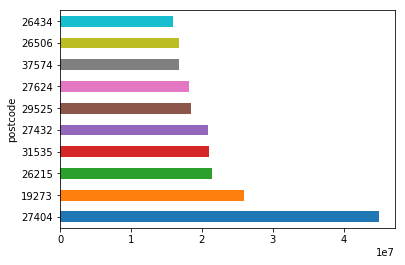

In [113]:
subsidies.groupby('postcode')['amount'].agg('sum').sort_values(ascending=False)[:10].plot.barh()

## By count

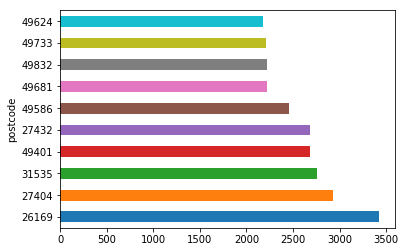

In [115]:
subsidies.groupby('postcode')['recipient_id'].agg('count').sort_values(ascending=False)[:10].plot.barh()

# Top 10 Postcodes Nitrate

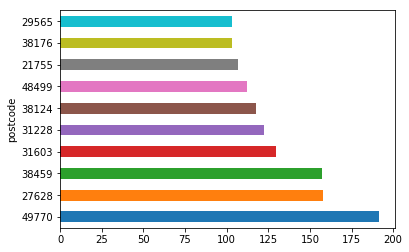

In [134]:
measurements.groupby('postcode')['Messwert'].agg('mean').sort_values(ascending=False)[:10].plot.barh()